# Evaluate MPNN Performance
Review the models which have been trained and pick one for our application.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import os

## Load in the Models
They are all located in a directory with a `test_summary.json` file

In [2]:
model_dirs = list(map(os.path.dirname, glob(os.path.join('networks', '**', 'test_summary.json'))))
print(f'Found {len(model_dirs)} model directories')

Found 12 model directories


In [3]:
def get_summary(path):
    """Get the summary of a run"""
    
    output = {'path': path}
    
    # Load the config
    with open(os.path.join(path, 'config.json')) as fp:
        output.update(json.load(fp))
        
    # Load in the run summary
    with open(os.path.join(path, 'test_summary.json')) as fp:
        output.update(json.load(fp))
    return output

In [4]:
models = pd.DataFrame(get_summary(p) for p in model_dirs).sort_values('mae')
models.head(5)

,path,atom_features,num_messages,output_layers,batch_size,num_epochs,readout_fn,overwrite,atomwise,r2_score,spearmanr,kendall_tau,mae,rmse,test_time
7,networks/T8_b32_n64_25f8bb,128,8,"[512, 256, 128]",32,64,max,True,False,0.839611,0.925060,0.783051,0.293306,0.431716,0.334188
6,networks/T8_b32_n256_671478,128,8,"[512, 256, 128]",32,256,max,True,False,0.843100,0.918431,0.775309,0.297446,0.435304,0.339976
3,networks/T8_b32_n128_6e1947,128,8,"[512, 256, 128]",32,128,max,False,False,0.826891,0.916944,0.768117,0.303094,0.451340,0.350387
9,networks/T8_b32_n128_57ddba,128,8,"[512, 256, 128]",32,128,mean,False,False,0.842743,0.917068,0.766606,0.303107,0.428731,0.349144
2,networks/T8_b32_n128_5c5342,128,8,"[512, 256, 128]",32,128,mean,False,True,0.835924,0.916470,0.764544,0.306863,0.437468,0.347001


## Validate the Best Model
Visualize the results on the hold-out set of 10% of our data

In [5]:
best_model = models.iloc[0]

In [6]:
best_model

path             networks/T8_b32_n64_25f8bb
atom_features                           128
num_messages                              8
output_layers               [512, 256, 128]
batch_size                               32
num_epochs                               64
readout_fn                              max
overwrite                              True
atomwise                              False
r2_score                           0.839611
spearmanr                           0.92506
kendall_tau                        0.783051
mae                                0.293306
rmse                               0.431716
test_time                          0.334188
Name: 7, dtype: object

In [7]:
test_data = pd.read_csv(os.path.join(best_model['path'], 'test_results.csv'))

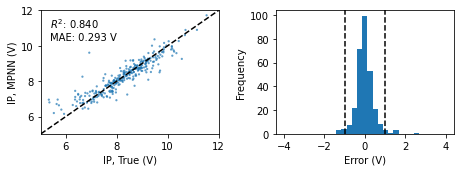

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

errors = (test_data['pred'] - test_data['true'])

ax = axs[0]
ax.scatter(test_data['true'], test_data['pred'], s=5, alpha=0.7, edgecolor='none')
ax.text(0.05, 0.95, f'$R^2$:{best_model["r2_score"]: .3f}\nMAE:{errors.abs().mean(): .3f} V', 
       transform=ax.transAxes, va='top', ha='left')

min_ = min(ax.get_xlim() + ax.get_ylim())
max_ = max(ax.get_xlim() + ax.get_ylim())
ax.set_xlim(min_, max_)
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('IP, True (V)')
ax.set_ylabel('IP, MPNN (V)')

ax = axs[1]


ax.hist(errors, bins=np.linspace(-4, 4, 32))

ax.set_ylim(ax.get_ylim())
ax.plot([-1, -1], ax.get_ylim(), 'k--')
ax.plot([1, 1], ax.get_ylim(), 'k--')

ax.set_xlabel('Error (V)')
ax.set_ylabel('Frequency')
fig.tight_layout()

Link the best model to the local directory

In [9]:
if os.path.exists('best_model.h5'):
    os.unlink('best_model.h5')
os.symlink(os.path.join(best_model['path'], 'best_model.h5'), 'best_model.h5')

In [10]:
if os.path.exists('best_config.json'):
    os.unlink('best_config.json')
os.symlink(os.path.join(best_model['path'], 'config.json'), 'best_config.json')

In [11]:
if os.path.exists('best_performance.json'):
    os.unlink('best_performance.json')
os.symlink(os.path.join(best_model['path'], 'test_summary.json'), 'best_performance.json')